# Import Libraries and Data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')

# Data Overview

In [3]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Compute values that are constant across columns
    total_rows = len(df)
    duplicates = df.duplicated().sum()

    # Use vectorized operations 
    dtypes = df.dtypes
    instances = df.count()
    unique = df.nunique()
    sum_null = df.isnull().sum()
    #null_percentage = (df.isnull().sum() / total_rows * 100).round(2)

    # Create the summary 
    df_check = pd.DataFrame({
        'column': df.columns,
        'dtype': dtypes,
        'instances': instances,
        'unique': unique,
        'sum_null': sum_null,
        #'null_percentage': null_percentage,
        'duplicates': duplicates  
    })

    return df_check

print("Train Data")
display(check(train))
display(train.head())

print("Test Data")
display(check(test))
display(test.head())

Train Data


,column,dtype,instances,unique,sum_null,duplicates
id,id,int64,593994,593994,0,0
annual_income,annual_income,float64,593994,119728,0,0
debt_to_income_ratio,debt_to_income_ratio,float64,593994,526,0,0
credit_score,credit_score,int64,593994,399,0,0
loan_amount,loan_amount,float64,593994,111570,0,0
interest_rate,interest_rate,float64,593994,1454,0,0
gender,gender,object,593994,3,0,0
marital_status,marital_status,object,593994,4,0,0
education_level,education_level,object,593994,5,0,0
employment_status,employment_status,object,593994,5,0,0


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


Test Data


,column,dtype,instances,unique,sum_null,duplicates
id,id,int64,254569,254569,0,0
annual_income,annual_income,float64,254569,67287,0,0
debt_to_income_ratio,debt_to_income_ratio,float64,254569,506,0,0
credit_score,credit_score,int64,254569,389,0,0
loan_amount,loan_amount,float64,254569,65199,0,0
interest_rate,interest_rate,float64,254569,1385,0,0
gender,gender,object,254569,3,0,0
marital_status,marital_status,object,254569,4,0,0
education_level,education_level,object,254569,5,0,0
employment_status,employment_status,object,254569,5,0,0


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1


# EDA

In [4]:
class AutoVisualizer:
    """
    Automatically generates univariate and bivariate visualizations
    for numeric, categorical, and datetime columns.
    """

    def __init__(self, train, test=None, target=None, max_cat=20):
        self.train = train.copy()
        self.test = test.copy() if test is not None else None
        self.target = target
        self.max_cat = max_cat

        # Robust column type detection
        self.num_cols = [c for c in train.columns if pd.api.types.is_numeric_dtype(train[c])]
        self.cat_cols = [c for c in train.columns if pd.api.types.is_object_dtype(train[c]) or pd.api.types.is_categorical_dtype(train[c])]
        self.dt_cols  = [c for c in train.columns if pd.api.types.is_datetime64_any_dtype(train[c])]

    def _get_dtype(self, series):
        if pd.api.types.is_numeric_dtype(series):
            return "numeric"
        elif pd.api.types.is_object_dtype(series) or pd.api.types.is_categorical_dtype(series):
            return "categorical"
        elif pd.api.types.is_datetime64_any_dtype(series):
            return "datetime"
        return "unknown"

    def plot_univariate(self):
        print("=== Univariate Analysis ===")
        
        for col in self.num_cols:
            if self.train[col].isnull().all(): 
                print(f"Skipping {col}: all NaN")
                continue
            plt.figure(figsize=(7, 4))
            sns.histplot(self.train[col].dropna(), kde=True, bins=30, color='skyblue')
            plt.title(f"Distribution of {col}")
            plt.tight_layout()
            plt.show()

        for col in self.cat_cols:
            if self.train[col].nunique() > self.max_cat:
                print(f"Skipping {col}: {self.train[col].nunique()} categories > {self.max_cat}")
                continue
            plt.figure(figsize=(8, max(4, len(self.train[col].value_counts()) * 0.3)))
            sns.countplot(y=col, data=self.train, order=self.train[col].value_counts().index, palette="viridis")
            plt.title(f"Count of {col}")
            plt.tight_layout()
            plt.show()

        for col in self.dt_cols:
            plt.figure(figsize=(10, 4))
            self.train[col].value_counts().sort_index().plot(kind='line', marker='o')
            plt.title(f"Time Series: {col}")
            plt.tight_layout()
            plt.show()

    def plot_bivariate(self):
        if not self.target or self.target not in self.train.columns:
            print("⚠️ No valid target provided for bivariate analysis.")
            return

        print(f"=== Bivariate Analysis (Target: {self.target}) ===")
        target_series = self.train[self.target]
        is_target_num = pd.api.types.is_numeric_dtype(target_series)

        # Numeric vs Target
        for col in self.num_cols:
            if col == self.target: 
                continue
            plt.figure(figsize=(8, 5))
            if is_target_num:
                sns.scatterplot(x=col, y=self.target, data=self.train, alpha=0.6)
                plt.title(f"{col} vs {self.target} (Num vs Num)")
            else:
                sns.boxplot(x=self.target, y=col, data=self.train)
                plt.title(f"{col} vs {self.target} (Num vs Cat)")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    def summarize(self):
        print("=== Dataset Summary ===")
        print(f"Train Rows: {len(self.train):,}")
        print(f"Numeric: {len(self.num_cols)} | Categorical: {len(self.cat_cols)} | Datetime: {len(self.dt_cols)}")
        if self.test is not None:
            print(f"Test Rows: {len(self.test):,}")
        print()

=== Dataset Summary ===
Train Rows: 593,994
Numeric: 7 | Categorical: 6 | Datetime: 0
Test Rows: 254,569

=== Univariate Analysis ===


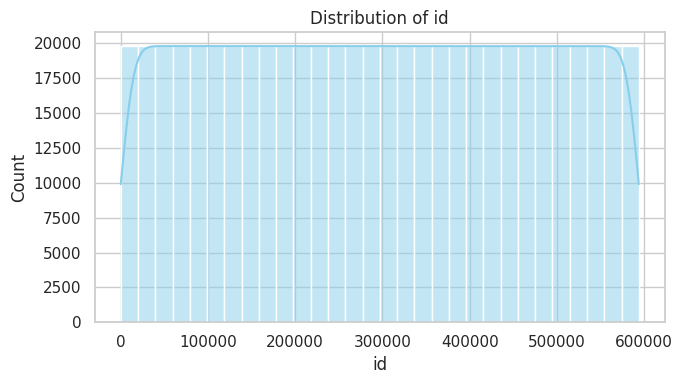

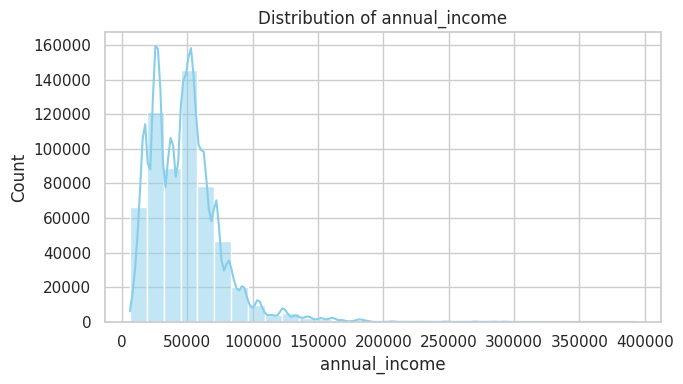

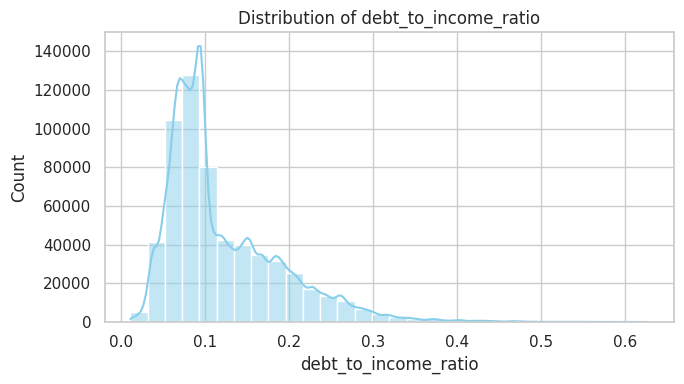

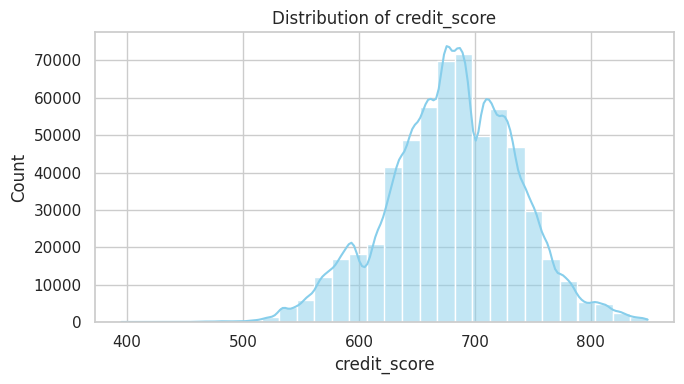

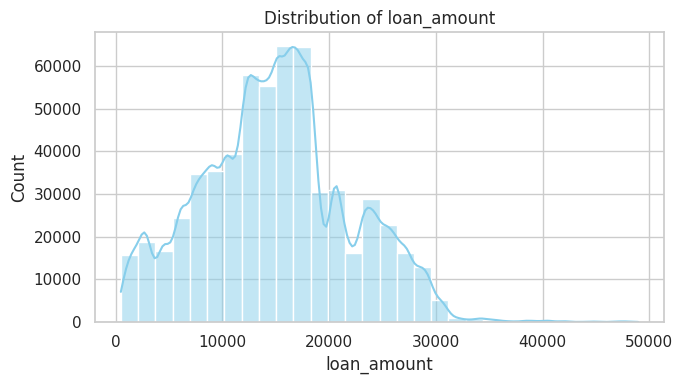

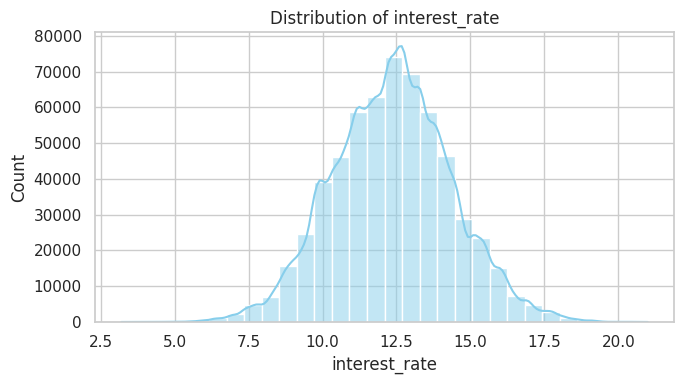

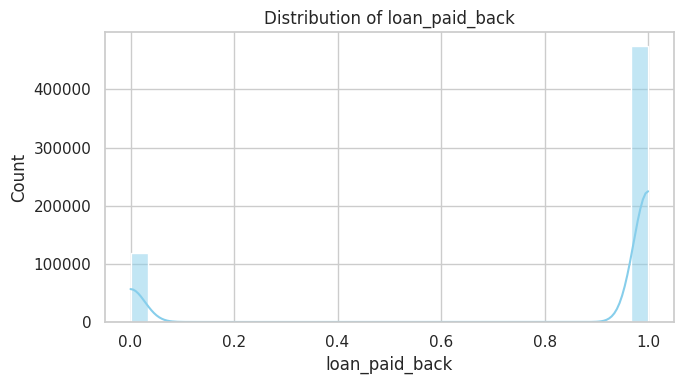

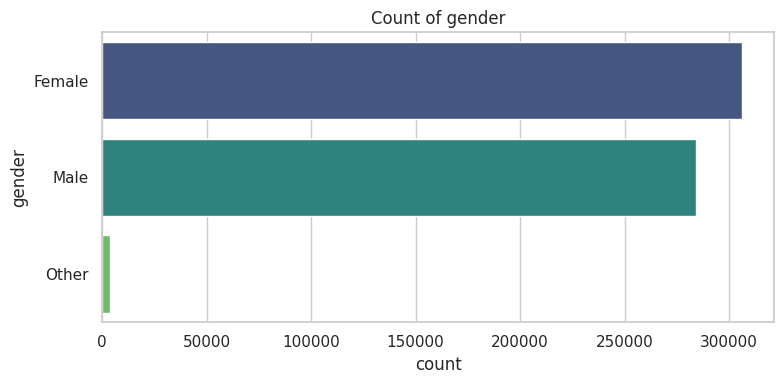

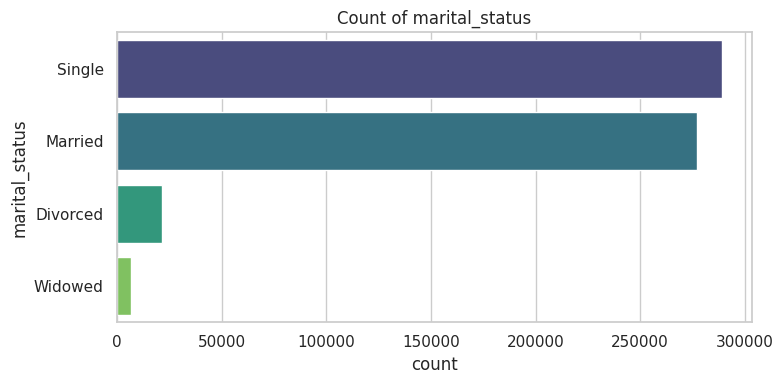

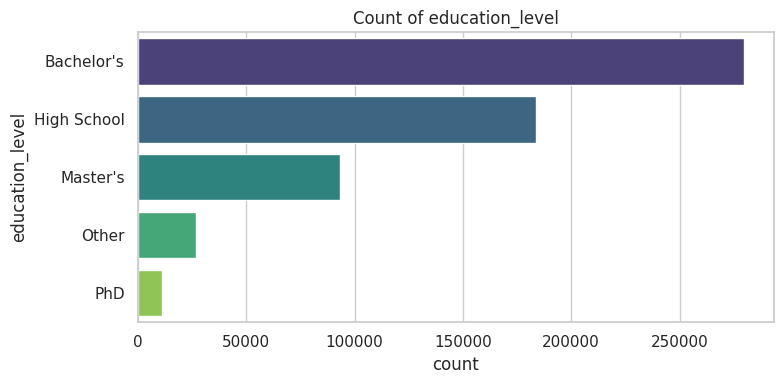

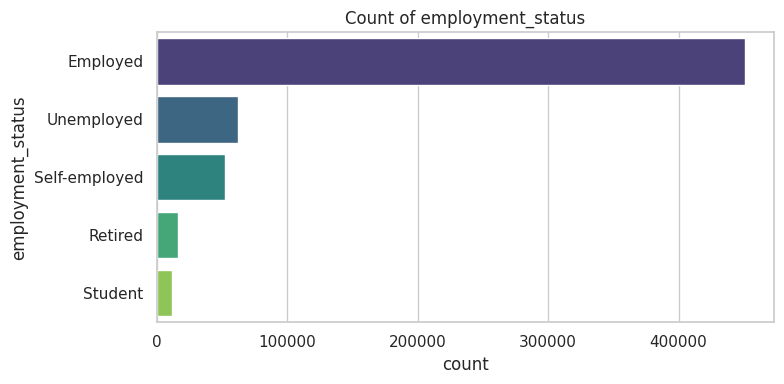

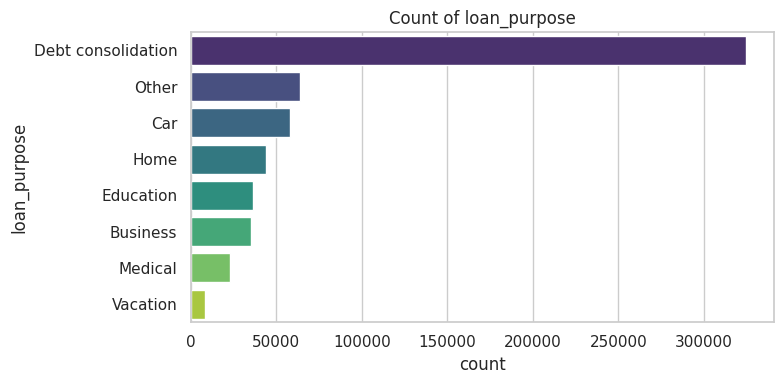

Skipping grade_subgrade: 30 categories > 20
=== Bivariate Analysis (Target: loan_paid_back) ===


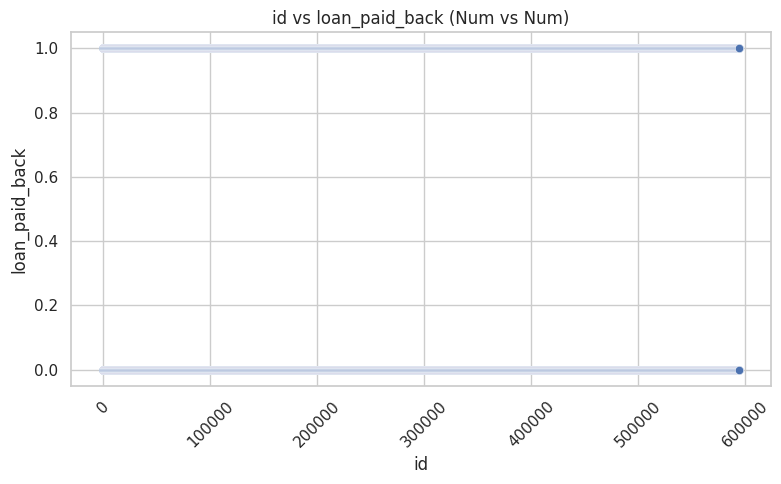

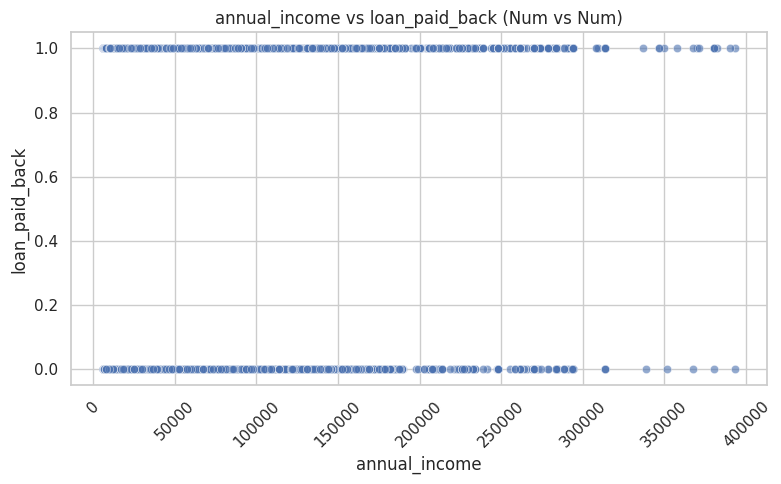

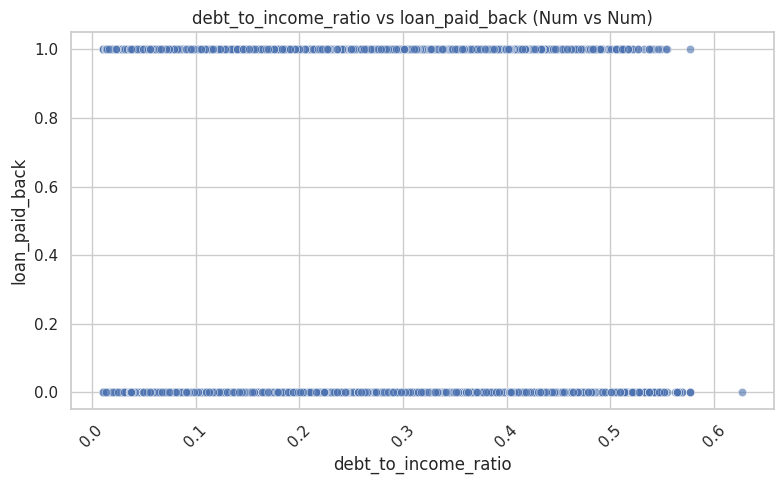

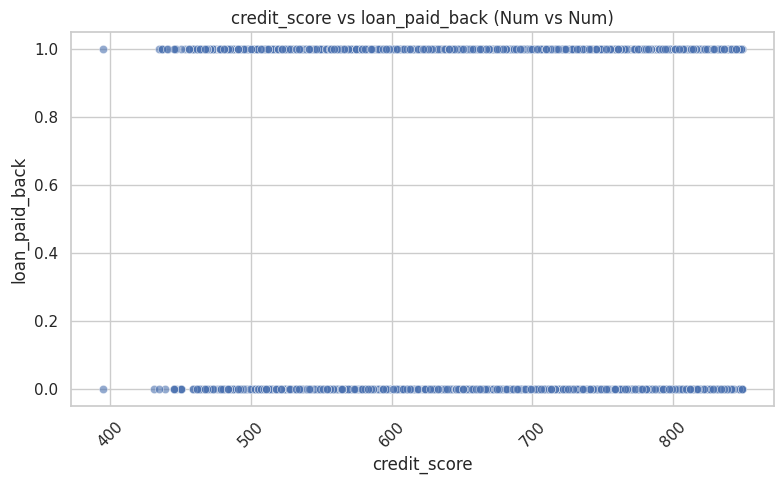

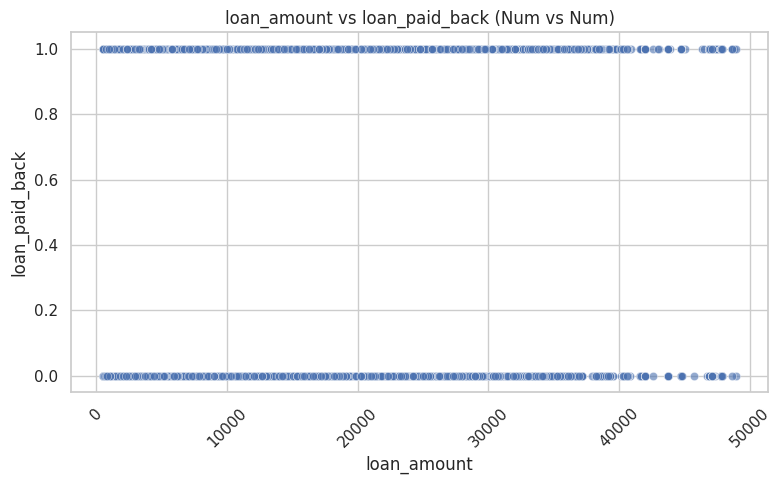

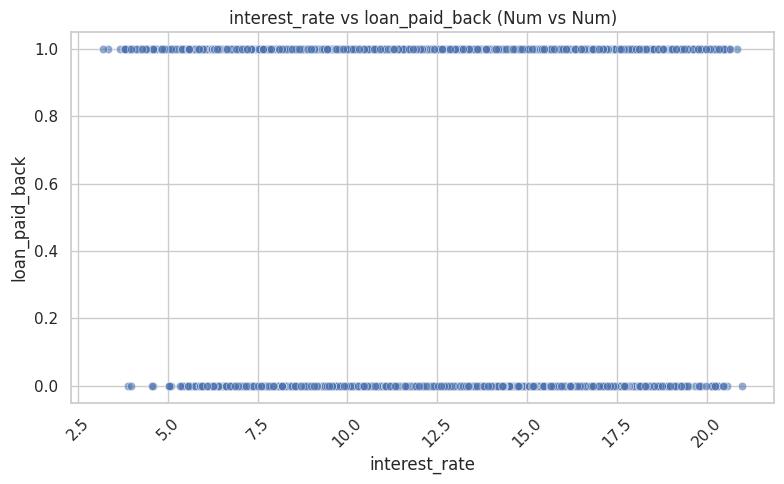

In [5]:
# Call Function
viz = AutoVisualizer(train, test, target='loan_paid_back')

viz.summarize()         # Quick summary of column types
viz.plot_univariate()   # Automatic histograms & counts
viz.plot_bivariate()    # Relationship plots vs target


In [6]:
# Create new features
# model
# eval  area under the ROC curve